In [6]:
%load_ext autoreload
%autoreload 2
from dnafiber.postprocess import refine_segmentation
from dnafiber.deployment import run_one_file, ENSEMBLE, Models
from dnafiber.data.utils import convert_rgb_to_mask
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from dnafiber.utils import DEFAULT_CMAP
import logging
import pandas as pd
import seaborn as sns
from dnafiber.analysis.ratios import (
    create_swarm_plot,
    create_violin_plot,
    create_boxen_plot,
    load_experiment,
    load_experiment_predictions,
    graders_statistical_test,
    compare_pairs
)

from tqdm.auto import tqdm  
for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
list_imgs = [
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/01/hela-20min-1_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/02/hela-20min-4_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/03/hela-20min-10_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/04/hela-30min-1_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/05/hela-30min-2_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/06/hela-30min-9_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/07/hela-40min-1_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/08/hela-40min-3_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/09/hela-40min-11_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/10/hela-60min-3_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/11/hela-60min-5_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/12/hela-60min-6_R3D.png"),
]
data_with_gt = dict(Ratio=[], Grader=[], Image=[], Length=[])
annotators = ["MM", "AE", "EF"]
gts = []
for img in tqdm(list_imgs):
    name = img.name
    parent_folder = img.parent
    fibers_gt = None
    for annotator in annotators:
        gt_path = parent_folder / f"{annotator}_Segm.png"
        gt = cv2.imread(str(gt_path), cv2.IMREAD_COLOR_RGB)
        h, w = gt.shape[:2]
        gt = convert_rgb_to_mask(gt)
        if fibers_gt is None:
            fibers_gt = refine_segmentation(None, gt)
        else:
            fibers_gt = fibers_gt.union(refine_segmentation(None, gt))
    fibers_gt = fibers_gt.valid_copy()
    data_with_gt["Ratio"] += fibers_gt.ratios
    data_with_gt["Grader"] += ["Human"] * len(fibers_gt)
    data_with_gt["Image"] += [name.split("-")[1]] * len(fibers_gt)

    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False)
    fibers_pred = fibers_pred.valid_copy()
    data_with_gt["Ratio"] += fibers_pred.ratios
    data_with_gt["Grader"] += ["AI"] * len(fibers_pred)
    data_with_gt["Image"] += [name.split("-")[1]] * len(fibers_pred)
    data_with_gt["Length"] += fibers_gt.lengths + fibers_pred.lengths





100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


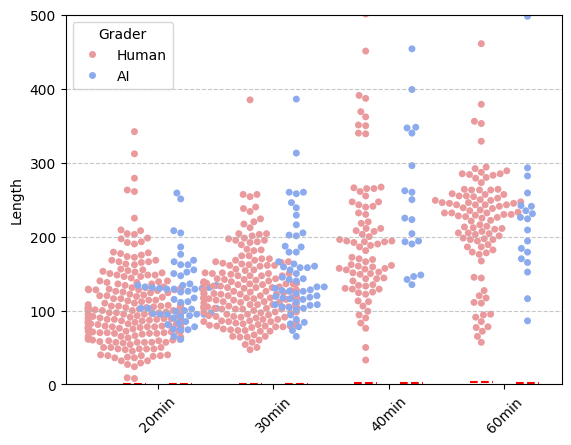

/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

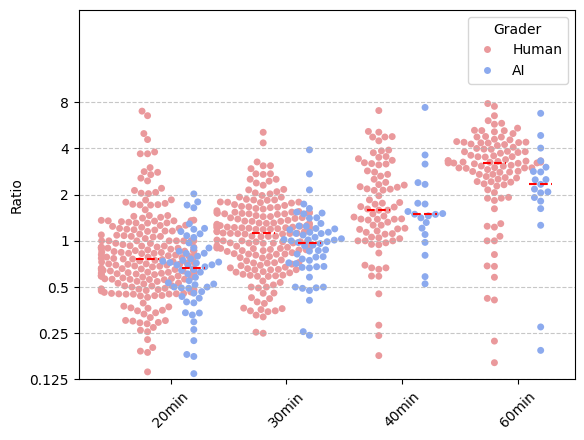

In [34]:


df = pd.DataFrame(data_with_gt)
df = df[df['Ratio']>0.125]
ai_color = "#8caaee"
human_color = "#ea999c"
palette = [human_color, ai_color]
df["Type"] = df["Image"]

df['Ratio'] = (1/df['Ratio'])
create_swarm_plot(df, palette=palette, column="Length", log_scale=False, yrange=(0, 500))
plt.show()

create_swarm_plot(df, palette=palette, column="Ratio")
# plt.ylim(0.125,8)
plt.show()

In [36]:
df[df.Grader == 'AI']['Image'].value_counts()

Image
30min    57
20min    56
40min    20
60min    19
Name: count, dtype: int64

In [ ]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/1-hutreated_greenfirst_redsecond_20mineach_redexpectedshorter/")
folders = list(root.iterdir())
folders.sort(key=lambda x: x.stem)
data = dict(Ratio=[], Image=[], FirstLength=[], SecondLength=[], Length=[])
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds
    data["Image"] += [root.stem] * len(fibers_pred)
    data["Length"] += fibers_pred.lengths



  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


In [15]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/2-MockTreated_GreenFirst_RedSecond_20minEach_RedExpectedEqual")
folders = list(root.iterdir())
folders = [f for f in folders if f.is_dir()]
folders.sort(key=lambda x: x.stem)
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["Image"] += [root.stem] * len(fibers_pred)
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds



100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


In [16]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/3-hutreated_ssdna_greenfirst_redsecond_bluessdna_20mineach_redexpectedshorter")
folders = list(root.iterdir())
folders = [f for f in folders if f.is_dir()]
folders.sort(key=lambda x: x.stem)
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    img[:,:, 2] = 0
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["Image"] += [root.stem] * len(fibers_pred)
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds



100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


In [17]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/4-MockTreated_GreenFirst_RedSecond_15minGreen_90minRed")
folders = list(root.iterdir())
folders = [f for f in folders if f.is_dir()]
folders.sort(key=lambda x: x.stem)
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["Image"] += [root.stem] * len(fibers_pred)
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds


100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


/tmp/ipykernel_223148/285447446.py:36: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 8)


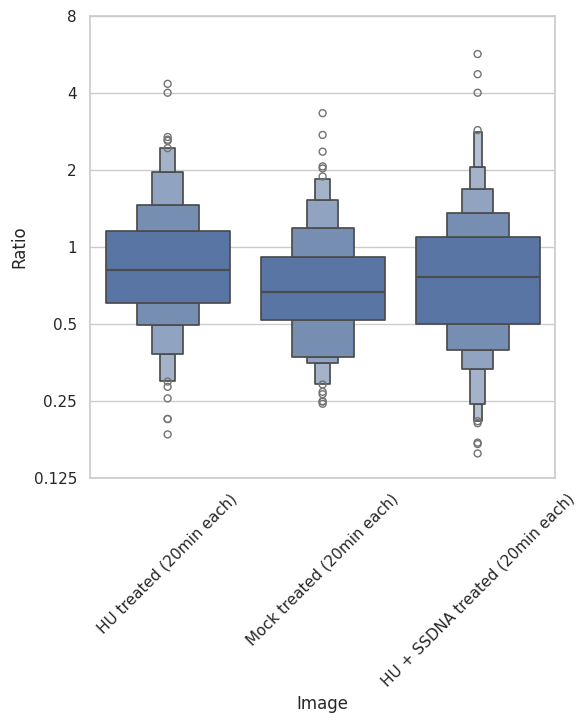

/tmp/ipykernel_223148/285447446.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 16)


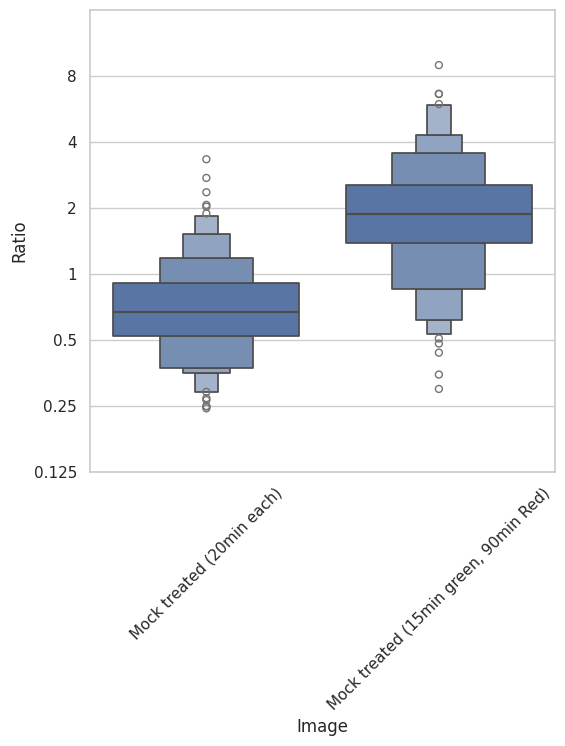

In [ ]:
import numpy as np
df = pd.DataFrame(data)


df1 = df.replace(
    {
        "Image": {
            "1-hutreated_greenfirst_redsecond_20mineach_redexpectedshorter": "HU treated (20min each)",
            "2-MockTreated_GreenFirst_RedSecond_20minEach_RedExpectedEqual": "Mock treated (20min each)",
            "3-hutreated_ssdna_greenfirst_redsecond_bluessdna_20mineach_redexpectedshorter": "HU + SSDNA treated (20min each)",
            "4-MockTreated_GreenFirst_RedSecond_15minGreen_90minRed": "Mock treated (15min green, 90min Red)",
        }
    }
)
df1["Ratio"] = 1 / df1["Ratio"].astype(float)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))

df_hu = df1[
    df1["Image"].isin(["HU treated (20min each)", "HU + SSDNA treated (20min each)", "Mock treated (20min each)", ])
]

df_hu = df_hu[df_hu["Ratio"] > 0.125]
sns.boxenplot(
    x="Image",
    y="Ratio",
    data=df_hu,
    linewidth=1.25,
)
plt.yscale("log")
plt.yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], [0.125, 0.25, 0.5, 1, 2, 4, 8])
# The y range should be from 0.125 to 8
# Remove minor ticks
plt.minorticks_off()
plt.ylim(0.125, 16)
plt.ylim(0, 8)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 6))

df_mock = df1[
    df1["Image"].isin(
        ["Mock treated (20min each)", "Mock treated (15min green, 90min Red)"]
    )
]
df_mock = df_mock[df_mock["Ratio"] > 0.125]
sns.boxenplot(
    x="Image",
    y="Ratio",
    data=df_mock,
    linewidth=1.25,
)
plt.yscale("log")
plt.yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], [0.125, 0.25, 0.5, 1, 2, 4, 8])
plt.minorticks_off()
plt.ylim(0.0, 16)
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_223148/2382185881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mock["FirstLength"] = df_mock["FirstLength"].astype(float) * 0.06773


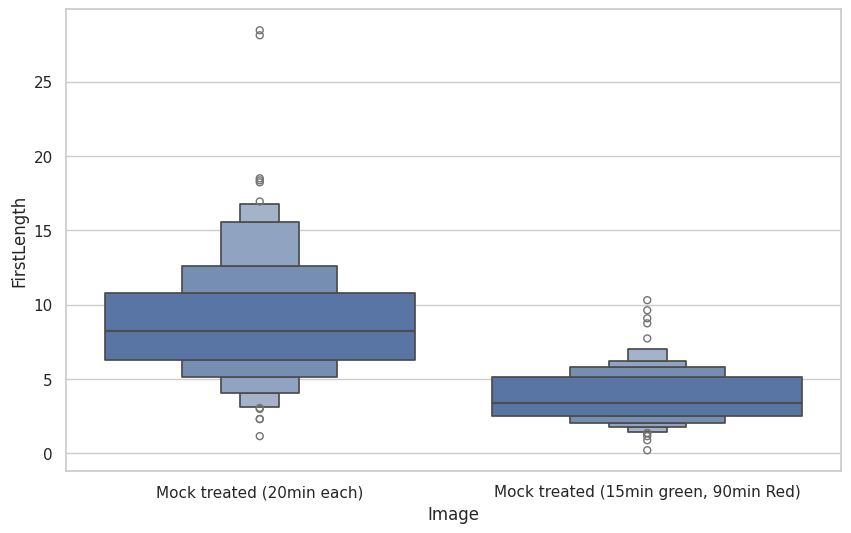

In [ ]:
df_mock = df1[
    df1["Image"].isin(
        ["Mock treated (20min each)", "Mock treated (15min green, 90min Red)"]
    )
]
# df_mock = df_mock[df_mock["Ratio"] > 0.125]
plt.figure(figsize=(10, 6))
df_mock["FirstLength"] = df_mock["FirstLength"].astype(float) * 0.06773
sns.boxenplot(
    x="Image",
    y="FirstLength",
    data=df_mock,
    linewidth=1.25,
)
# plt.yscale("log")
# plt.yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], [0.125, 0.25, 0.5, 1, 2, 4, 8])
# plt.minorticks_off()
# plt.ylim(0.0, 16)
# plt.xticks(rotation=45)
plt.show()

In [ ]:
df_mock

,Ratio,Image,FirstLength,SecondLength
166,0.400000,Mock treated (20min each),420,168
167,0.907801,Mock treated (20min each),141,128
168,0.788462,Mock treated (20min each),104,82
169,0.740000,Mock treated (20min each),200,148
170,0.658333,Mock treated (20min each),120,79
...,...,...,...,...
771,0.538462,"Mock treated (15min green, 90min Red)",39,21
772,1.461538,"Mock treated (15min green, 90min Red)",78,114
773,0.674699,"Mock treated (15min green, 90min Red)",83,56
774,2.388889,"Mock treated (15min green, 90min Red)",36,86
